# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from read_spin_configs import read_temp_dependent_files_then_merge
from percolation import read_percolation_data
from sklearn.model_selection import train_test_split
import sys

# Loading and preprocessing the data

In [2]:
idir = r'/Users/matthieu.sarkis/git_repos/criticality_data/config-files/L=128'
L = 128
Tc = 2.2692
#T_arr = np.round(np.arange(1.8, 3.0, 0.01),4)
T_arr = np.round(np.array([2.25, 2.26, 2.28, 2.29]), 4)
T_arr = np.append(T_arr, Tc)

In [3]:
X, y = read_temp_dependent_files_then_merge(idir, L, T_arr, Tc, max_configs_per_temperature=1000)

In [4]:
print(X.shape, y.shape)

(0, 128, 128, 1) (0,)


In [27]:
N = X.shape[0]
L = X.shape[1] 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [29]:
print('X.shape:', X.shape, ', y.shape:', y.shape)
print('X_train.shape:', X_train.shape, ', y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape, ', y_test.shape:', y_test.shape)

X.shape: (5000, 128, 128, 1) , y.shape: (5000,)
X_train.shape: (4000, 128, 128, 1) , y_train.shape: (4000,)
X_test.shape: (1000, 128, 128, 1) , y_test.shape: (1000,)


In [30]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 5


# Definition of the network and training for classification

In [31]:
def CNN_net(L, K):
    # input layer
    i = Input(shape=(L,L,1))

    # Convolution block
    x = Conv2D(32, (3,3), activation='relu', padding='same')(i)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    # Classification block
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(K, activation='softmax')(x)

    model = Model(i, x)
    return model

In [32]:
model_phase = CNN_net(L, K)

In [33]:
# Compiling the model

# Inverse time decaying learning rate
# initial_learning_rate / (1 + decay_rate * floor(step / decay_step))
initial_learning_rate = 0.01
decay_steps = 1.0
decay_rate = 0.5
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate, decay_steps, decay_rate)

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
model_phase.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
# data augmentation, we allow for rotations of the image.
# At critical temperature, one could also allow for scalings?
#batch_size = 20
#data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=90, horizontal_flip=True, vertical_flip=True)
#train_generator = data_generator.flow(X_train, y_train, batch_size)
#steps_per_epochs = X_train.shape[0] // batch_size

In [35]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, mode='min')

#initial_learning_rate = 0.01
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.001)

In [36]:
#opt = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
#model_phase.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
# training the model
#r_phase = model_phase.fit(train_generator, validation_data=(X_test, y_test), steps_per_epoch=steps_per_epochs, epochs=50)
r_phase = model_phase.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, callbacks=[early_stop])

Epoch 1/15
125/125 [==============================] - 236s 2s/step - loss: 36.7785 - accuracy: 0.6342 - val_loss: 21.5794 - val_accuracy: 0.5480
Epoch 2/15
125/125 [==============================] - 249s 2s/step - loss: 3.5724 - accuracy: 0.7582 - val_loss: 263.6311 - val_accuracy: 0.3090
Epoch 3/15
125/125 [==============================] - 250s 2s/step - loss: 2.4177 - accuracy: 0.7875 - val_loss: 147.9350 - val_accuracy: 0.4940
Epoch 4/15
125/125 [==============================] - 256s 2s/step - loss: 1.7896 - accuracy: 0.8062 - val_loss: 46.3852 - val_accuracy: 0.6710
Epoch 5/15
125/125 [==============================] - 246s 2s/step - loss: 1.4309 - accuracy: 0.8313 - val_loss: 2.0651 - val_accuracy: 0.8180
Epoch 6/15
125/125 [==============================] - 246s 2s/step - loss: 1.3882 - accuracy: 0.8305 - val_loss: 0.4138 - val_accuracy: 0.9080
Epoch 7/15
125/125 [==============================] - 256s 2s/step - loss: 1.0763 - accuracy: 0.8425 - val_loss: 0.3617 - val_accuracy:

In [38]:
# We save the model
model_phase.save('../../../criticality_trained_models/cnn_ising_phase([2.25, 2.26, 2.28, 2.29, Tc],L=128,max_per_temp=1000).h5')

In [39]:
# to load it:
#model_phase = tf.keras.models.load_model('~/ml/research/criticality_trained_models/cnn_ising_phase.h5')

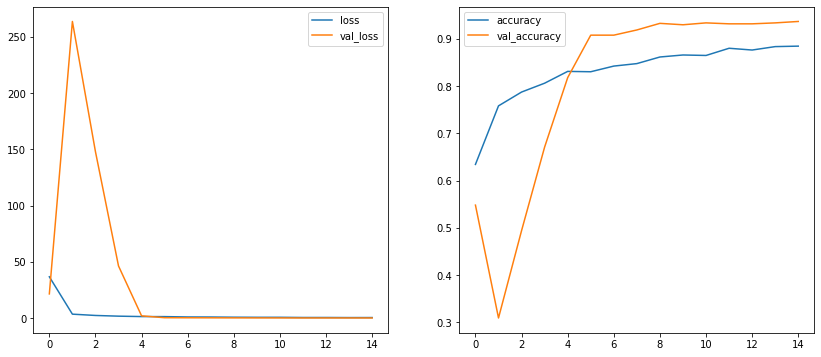

In [40]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(r_phase.history['loss'], label='loss')
plt.plot(r_phase.history['val_loss'], label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(r_phase.history['accuracy'], label='accuracy')
plt.plot(r_phase.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [41]:
# Let us plot the confusion matrix
p_test = model_phase.predict(X_test).argmax(axis=1)
conf_matrix = confusion_matrix(y_test, p_test)

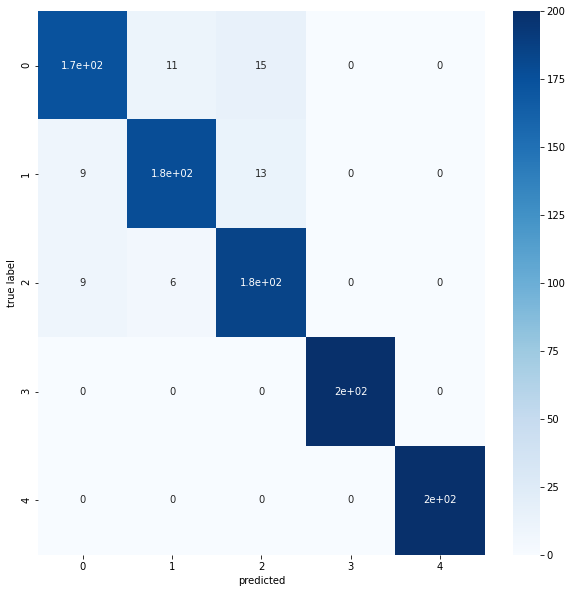

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, cmap='Blues', annot=True)
plt.xlabel('predicted')
plt.ylabel('true label')
plt.savefig('../saved_images/cnn_ising_phase([2.25, 2.26, 2.28, 2.29, Tc],L=128,max_per_temp=1000).jpg')
plt.show()

In [56]:
model_previous = tf.keras.models.load_model('../../criticality_trained_models/cnn_ising_phase([2.25, 2.26, 2.28, 2.29],L=256).h5')
idir = r'/Users/matthieu.sarkis/ml/research/criticality_data/config-files/L=256'
L = 256
T_arr = np.append(np.round(np.array([2.25, 2.26, 2.28, 2.29]),4), Tc)
X_test, y_test = read_temp_dependent_files_then_merge(idir, L, T_arr, Tc, max_configs_per_temperature=1000)
p_test = model_previous.predict(X_test).argmax(axis=1)
p_test = np.where(p_test == 0, -1, p_test)
p_test = np.where(p_test > 0, 0, p_test)
p_test = np.where(p_test == -1, 1, p_test)

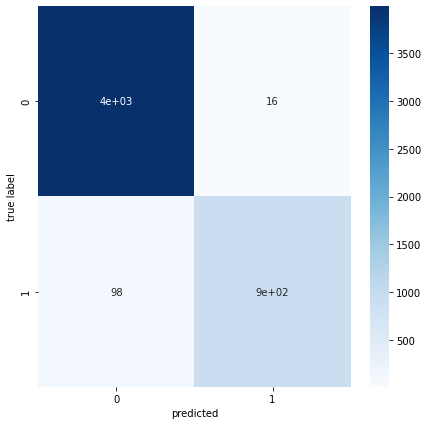

In [57]:
conf_matrix_previous = confusion_matrix(y_test, p_test)
plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix_previous, cmap='Blues', annot=True)
plt.xlabel('predicted')
plt.ylabel('true label')
plt.show()

# Testing on percolation the CNN trained on Ising

In [2]:
# to load it:
model_trained_on_ising = tf.keras.models.load_model('../../criticality_trained_models/cnn_ising_phase([2.25, 2.26, 2.28, 2.29],L=256).h5')

In [8]:
L = 256
pc = 0.59274
p_arr = np.round(np.array([0.57, 0.58, 0.61, 0.62]), 4)
p_arr = np.append(p_arr, pc)
X_perco, y_perco = read_percolation_data(L, p_arr, pc, max_configs_per_p=1000)

In [9]:
# Let us plot the confusion matrix
p_test = model_trained_on_ising.predict(X_perco).argmax(axis=1)

In [10]:
p_test = np.where(p_test == 0, -1, p_test)
p_test = np.where(p_test > 0, 0, p_test)
p_test = np.where(p_test == -1, 1, p_test)

conf_matrix_perco = confusion_matrix(y_perco, p_test)

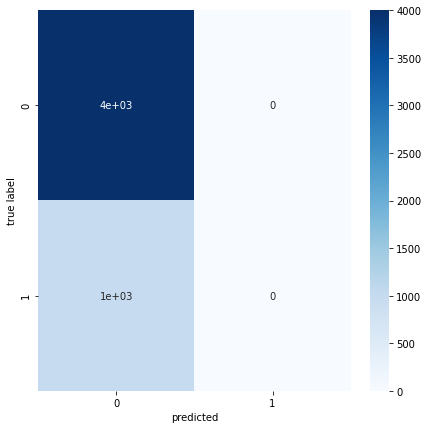

In [11]:
plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix_perco, cmap='Blues', annot=True)
plt.xlabel('predicted')
plt.ylabel('true label')
plt.show()